##Importamos nuestras librerias

In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import imagehash
import os
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

##Se declara la ruta donde está el dataset de imágenes

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mykhailokosiuk/facial-gestures")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/facial-gestures


## Clases y cantidad de fotos por cada clase



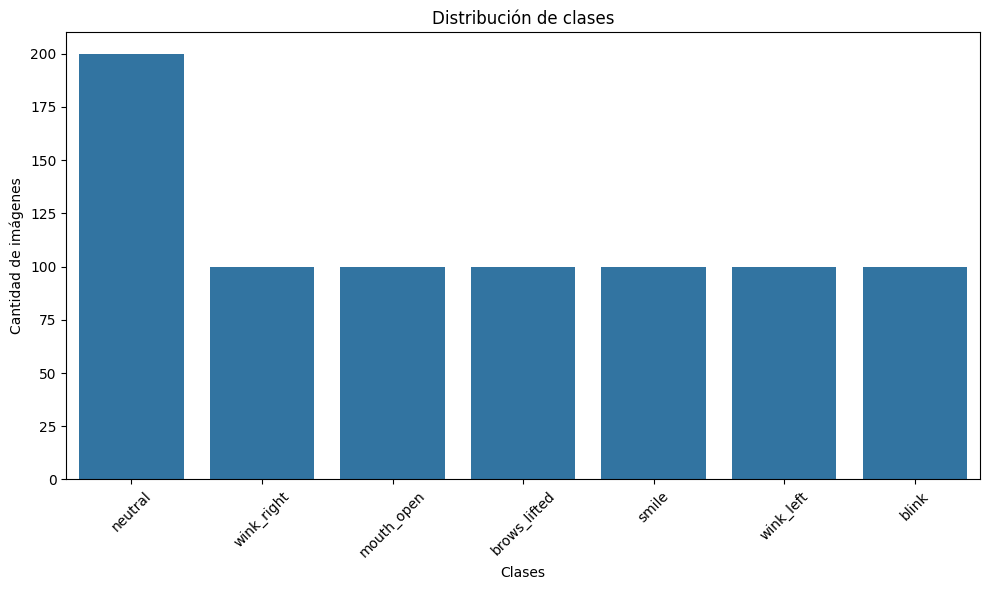

In [ ]:
dataset_dir = os.path.join(path, "dataset")

# Contar imágenes por clase (subcarpeta)
clases_cant = {}

for clase in os.listdir(dataset_dir):
    clase_path = os.path.join(dataset_dir, clase)
    if os.path.isdir(clase_path):
        count = len([
            f for f in os.listdir(clase_path)
            if os.path.isfile(os.path.join(clase_path, f))
        ])
        clases_cant[clase] = count

# Crear DataFrame
df = pd.DataFrame.from_dict(clases_cant, orient='index', columns=['count'])
df = df.sort_values(by='count', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=df.index, y='count', data=df)
plt.xlabel('Clases')
plt.ylabel('Cantidad de imágenes')
plt.xticks(rotation=45)
plt.title("Distribución de clases")
plt.tight_layout()
plt.show()

In [ ]:
clases=list(clases_cant.keys())
clases

['wink_right',
 'neutral',
 'mouth_open',
 'brows_lifted',
 'smile',
 'wink_left',
 'blink']

##Imagenes de ejemplo

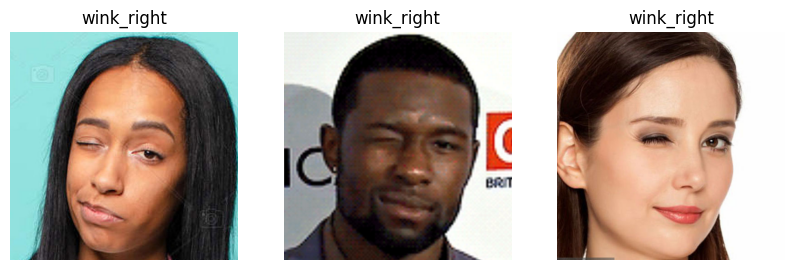

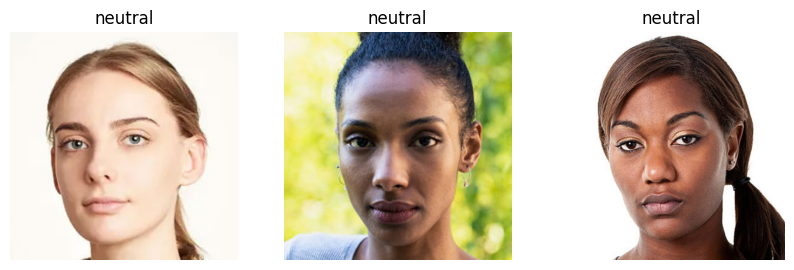

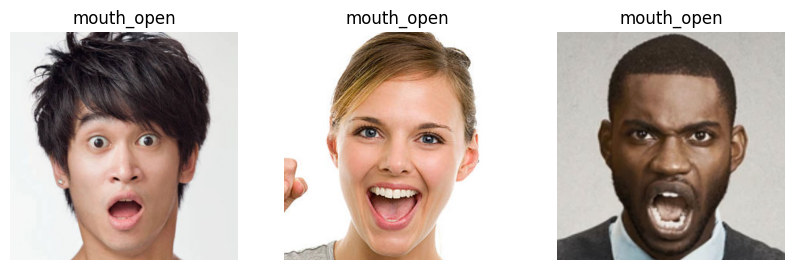

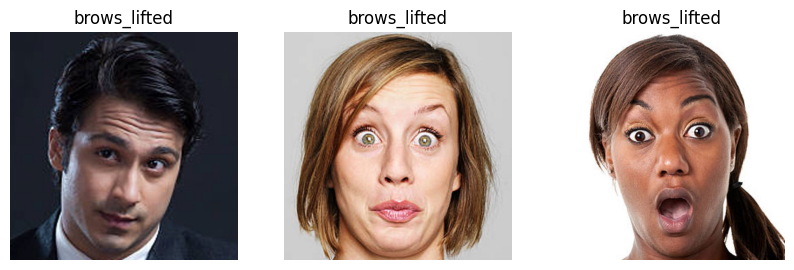

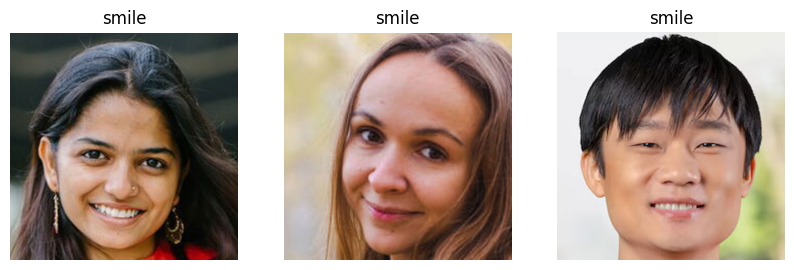

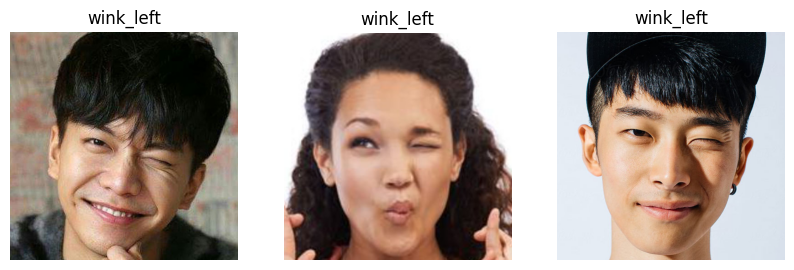

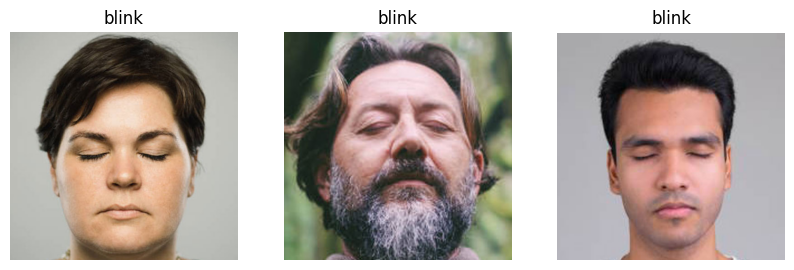

In [ ]:
def mostrar_imagenes_ejemplo(dataset_path, clases, n=3):
    dataset_path_inner = os.path.join(dataset_path, os.listdir(dataset_path)[0]) # Assuming 'dataset' is the first folder

    for clase in clases:
        folder = os.path.join(dataset_path_inner, clase)
        imagenes = os.listdir(folder)[:n]
        plt.figure(figsize=(10, 3))
        for i, img_file in enumerate(imagenes):
            img_path = os.path.join(folder, img_file)
            img = Image.open(img_path)
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.title(clase)
            plt.axis('off')
        plt.show()

mostrar_imagenes_ejemplo(path, clases)

##Tamaños de las imagenes

In [ ]:
tamaños = []
dataset_path_inner = os.path.join(path, os.listdir(path)[0]) # Assuming 'dataset' is the first folder

for cls in clases:
    for img_name in os.listdir(os.path.join(dataset_path_inner, cls))[:800]:
        img_path = os.path.join(dataset_path_inner, cls, img_name)
        try:
            img = Image.open(img_path)
            tamaños.append(img.size)
        except:
            pass

print("Distribución de tamaños de imagen:")
print(Counter(tamaños).most_common(5))

Distribución de tamaños de imagen:
[((500, 500), 656), ((500, 498), 45), ((500, 501), 35), ((500, 502), 25), ((500, 499), 24)]


In [ ]:
def verificar_imagenes(dataset_path):
    dataset_path_inner = os.path.join(dataset_path, os.listdir(dataset_path)[0]) # Assuming 'dataset' is the first folder
    imagenes_corruptas = []
    for cls in clases:
        for img_name in os.listdir(os.path.join(dataset_path_inner, cls)):
            img_path = os.path.join(dataset_path_inner, cls, img_name)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                imagenes_corruptas.append(img_path)
    return imagenes_corruptas

imagenes_corruptas = verificar_imagenes(path)
print(f"Cantidad de imágenes corruptas: {len(imagenes_corruptas)}")

Cantidad de imágenes corruptas: 0


In [ ]:
def normalize_image_size(dataset_path, output_path, target_size=(200, 200)):
    dataset_path_inner = os.path.join(dataset_path, os.listdir(dataset_path)[0]) # Assuming 'dataset' is the first folder
    output_path_inner = os.path.join(output_path, os.listdir(dataset_path)[0]) # Assuming 'dataset' is the first folder
    os.makedirs(output_path_inner, exist_ok=True)

    for cls in os.listdir(dataset_path_inner):
        class_path = os.path.join(dataset_path_inner, cls)
        output_class_path = os.path.join(output_path_inner, cls)
        os.makedirs(output_class_path, exist_ok=True)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                output_img_path = os.path.join(output_class_path, img_name)
                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path)
                        img = img.resize(target_size, Image.LANCZOS)
                        img.save(output_img_path)
                    except Exception as e:
                        print(f"Could not process image {img_path}: {e}")


# Define the output path for normalized images
normalized_dataset_path = '/kaggle/working/normalized_facial_gestures'
normalize_image_size(path, normalized_dataset_path)

In [ ]:
from PIL import ImageEnhance, ImageOps
import random

In [ ]:
def augment_image(img):
    # Aplicar transformaciones aleatorias
    if random.random() < 0.5:
        img = ImageOps.mirror(img)
    if random.random() < 0.5:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.7, 1.3))
    if random.random() < 0.5:
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.7, 1.3))
    if random.random() < 0.5:
        angle = random.choice([90, 180, 270])
        img = img.rotate(angle)
    return img

# Rellenar clases hasta que todas tengan la misma cantidad de imágenes
normalized_dataset_inner = os.path.join(normalized_dataset_path, os.listdir(normalized_dataset_path)[0])
clase_counts = {cls: len(os.listdir(os.path.join(normalized_dataset_inner, cls)))
                for cls in os.listdir(normalized_dataset_inner)
                if os.path.isdir(os.path.join(normalized_dataset_inner, cls))}

max_count = max(clase_counts.values())

for cls, count in clase_counts.items():
    class_dir = os.path.join(normalized_dataset_inner, cls)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    i = 0
    while len(images) < max_count:
        img_name = images[i % len(images)]
        img_path = os.path.join(class_dir, img_name)
        try:
            img = Image.open(img_path)
            aug_img = augment_image(img)
            new_name = f"aug_{i}_{img_name}"
            aug_img.save(os.path.join(class_dir, new_name))
            images.append(new_name)
            i += 1
        except Exception as e:
            print(f"Error augmenting {img_path}: {e}")

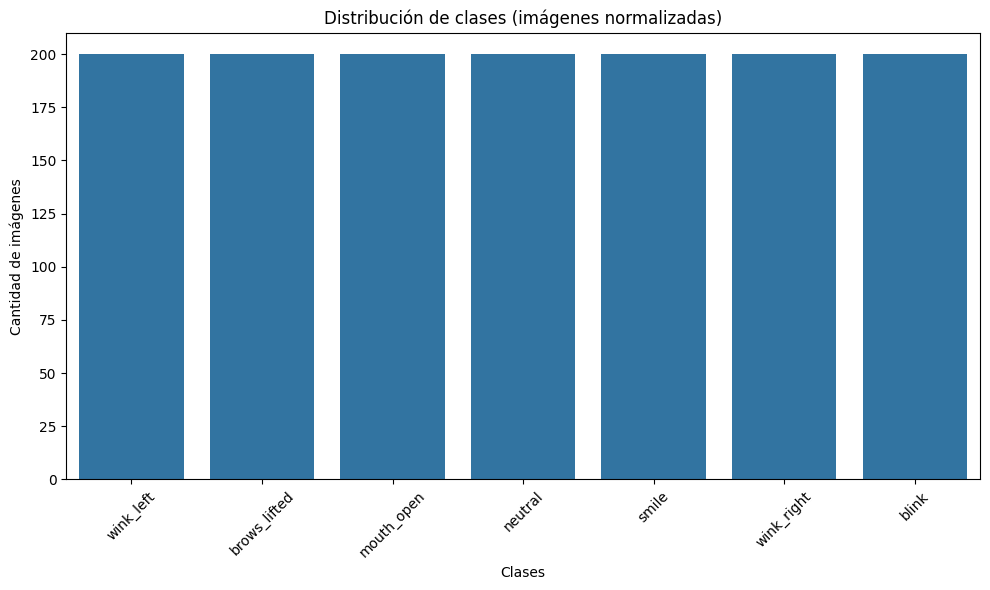

In [ ]:
# Contar imágenes por clase en el dataset normalizado
clases_cant = {}
normalized_dataset_inner = os.path.join(normalized_dataset_path, os.listdir(normalized_dataset_path)[0])

for clase in os.listdir(normalized_dataset_inner):
    clase_path = os.path.join(normalized_dataset_inner, clase)
    if os.path.isdir(clase_path):
        count = len([
            f for f in os.listdir(clase_path)
            if os.path.isfile(os.path.join(clase_path, f))
        ])
        clases_cant[clase] = count

# Crear y graficar DataFrame
df = pd.DataFrame.from_dict(clases_cant, orient='index', columns=['count'])
df = df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=df.index, y='count', data=df)
plt.xlabel('Clases')
plt.ylabel('Cantidad de imágenes')
plt.xticks(rotation=45)
plt.title("Distribución de clases (imágenes normalizadas)")
plt.tight_layout()
plt.show()

MODELADO

###CNN

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Usamos el dataset normalizado y aumentado
normalized_dataset_inner = os.path.join(normalized_dataset_path, os.listdir(normalized_dataset_path)[0])

# Recolectar rutas de imágenes y etiquetas
image_paths = []
labels = []
for cls in os.listdir(normalized_dataset_inner):
    class_dir = os.path.join(normalized_dataset_inner, cls)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(cls)

# Dividir en entrenamiento y validación
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=6, stratify=labels
)

# Crear DataFrames
train_df = pd.DataFrame({'filepaths': train_paths, 'labels': train_labels})
val_df = pd.DataFrame({'filepaths': val_paths, 'labels': val_labels})

# Generadores de imágenes (solo reescalado, ya hay aumentación previa)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)


Found 1120 validated image filenames belonging to 7 classes.
Found 280 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1569 - loss: 3.0220

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.1580 - loss: 3.0017 - val_accuracy: 0.2461 - val_loss: 1.8507 - learning_rate: 0.0010
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.3612 - loss: 1.6825 - val_accuracy: 0.4023 - val_loss: 1.6257 - learning_rate: 0.0010
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.5212 - loss: 1.3568 - val_accuracy: 0.4375 - val_loss: 1.5684 - learning_rate: 0.0010
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.6528 - loss: 1.0272 - val_accuracy: 0.5195 - val_loss: 1.5361 - learning_rate: 0.0010
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.7893 - loss: 0.6399 - val_accuracy: 0.5117 - val_loss: 1.6501 - learning_rate: 0.0010
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 769ms/step - accuracy: 0.5319 - loss: 1.4442
Validation Loss: 1.6030105352401733
Validation Accuracy: 0.5214285850524902


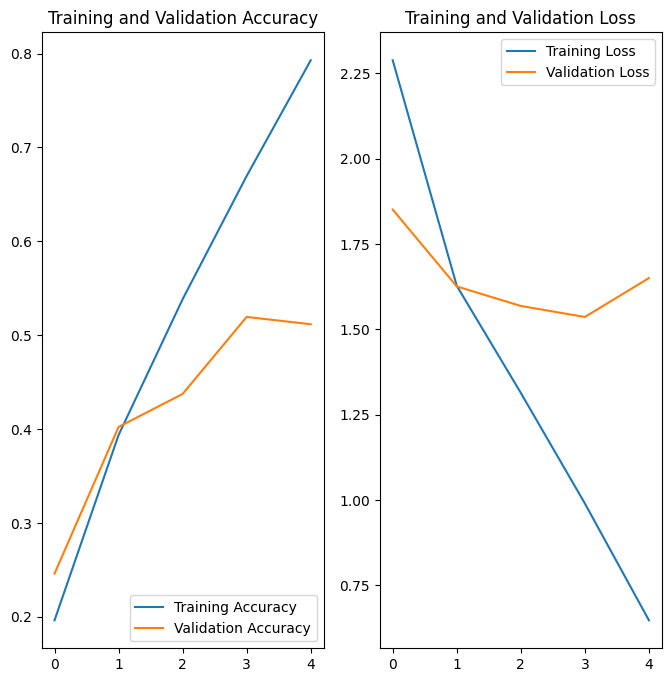

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Número de clases
num_classes = len(train_generator.class_indices)

# Definir modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilar modelo
optimizer = Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[lr_scheduler]
)

# Evaluar modelo
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Graficar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
#imporimir precision del modelo
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Validation Loss: [2.2879836559295654, 1.6274409294128418, 1.3137918710708618, 0.9900038838386536, 0.6478152871131897]
Validation Accuracy: 0.5214285850524902


In [ ]:
val_generator_reset = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(200, 200),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

preds = model.predict(val_generator_reset, steps=val_generator_reset.samples)


y_pred = np.argmax(preds, axis=1)


y_true = val_generator_reset.classes


class_names = list(val_generator_reset.class_indices.keys())

Found 280 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


280/280 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step


Matriz de confusión

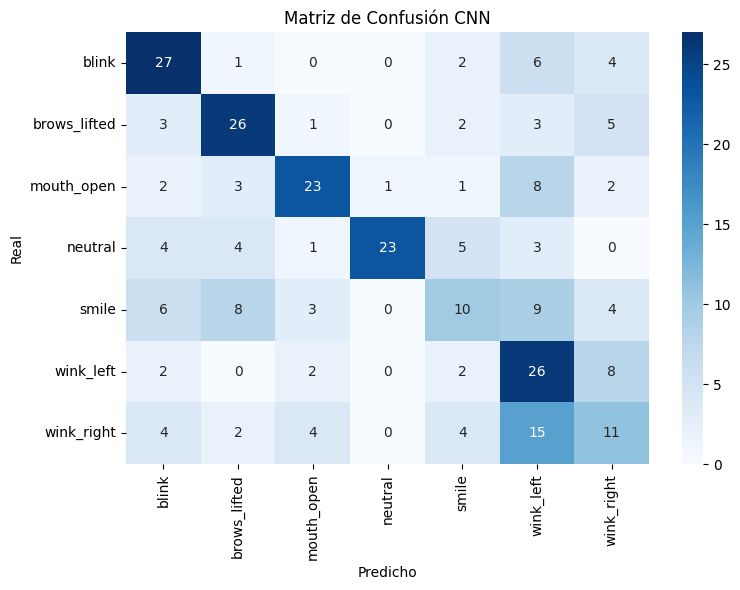

In [ ]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
class_names = list(val_generator_reset.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión CNN")
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Reporte de métricas por clase:\n")
print(report)

Reporte de métricas por clase:

              precision    recall  f1-score   support

       blink     0.5625    0.6750    0.6136        40
brows_lifted     0.5909    0.6500    0.6190        40
  mouth_open     0.6765    0.5750    0.6216        40
     neutral     0.9583    0.5750    0.7188        40
       smile     0.3846    0.2500    0.3030        40
   wink_left     0.3714    0.6500    0.4727        40
  wink_right     0.3235    0.2750    0.2973        40

    accuracy                         0.5214       280
   macro avg     0.5525    0.5214    0.5209       280
weighted avg     0.5525    0.5214    0.5209       280



###ATTENTION

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

# Definir el bloque de atención espacial
class SpatialAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Convolución para generar mapa de atención
        self.conv1 = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        # Calcular estadísticas por canal
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)  # Promedio por canal
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)   # Máximo por canal

        # Concatenar estadísticas
        concat = tf.concat([avg_pool, max_pool], axis=-1)

        # Generar mapa de atención
        attention_map = self.conv1(concat)

        # Aplicar atención a la entrada
        return inputs * attention_map

# Definir el bloque de atención por canal
class ChannelAttention(layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channels = input_shape[-1]

        # Capas densas para el mecanismo de atención
        self.dense1 = layers.Dense(self.channels // self.reduction_ratio, activation='relu')
        self.dense2 = layers.Dense(self.channels, activation='sigmoid')

        # Pooling layers
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.global_max_pool = layers.GlobalMaxPooling2D()

        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        # Average pooling path
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = layers.Reshape((1, 1, self.channels))(avg_pool)
        avg_pool = self.dense1(avg_pool)
        avg_pool = self.dense2(avg_pool)

        # Max pooling path
        max_pool = self.global_max_pool(inputs)
        max_pool = layers.Reshape((1, 1, self.channels))(max_pool)
        max_pool = self.dense1(max_pool)
        max_pool = self.dense2(max_pool)

        # Combinar ambos paths
        attention = avg_pool + max_pool

        # Aplicar atención
        return inputs * attention

# Bloque CBAM (Convolutional Block Attention Module)
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channel_attention = ChannelAttention(reduction_ratio)
        self.spatial_attention = SpatialAttention()

    def call(self, inputs):
        # Aplicar atención por canal primero
        x = self.channel_attention(inputs)
        # Luego atención espacial
        x = self.spatial_attention(x)
        return x

# Función para crear el modelo CNN con atención
def create_attention_cnn_model(input_shape=(200, 200, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Primer bloque convolucional
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = CBAM(reduction_ratio=16)(x)  # Aplicar atención
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.25)(x)

    # Segundo bloque convolucional
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = CBAM(reduction_ratio=16)(x)  # Aplicar atención
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.25)(x)

    # Tercer bloque convolucional
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = CBAM(reduction_ratio=16)(x)  # Aplicar atención
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.25)(x)

    # Cuarto bloque convolucional
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = CBAM(reduction_ratio=16)(x)  # Aplicar atención
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.25)(x)

    # Capas densas finales
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Crear el modelo con atención
attention_model = create_attention_cnn_model(input_shape=(200, 200, 3), num_classes=num_classes)

# Compilar modelo
optimizer = Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

attention_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen del modelo
attention_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 200, 200, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_4 (CBAM)                   │ (None, 200, 200, 32)   │           261 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_5 (CBAM)                   │ (None, 100, 100, 64)   │           679 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_6 (CBAM)                   │ (None, 50, 50, 128)    │         2,283 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_7 (CBAM)                   │ (None, 25, 25, 256)    │         8,56

 Total params: 1,450,673 (5.53 MB)

 Trainable params: 1,449,713 (5.53 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:

# Entrenar modelo
history = attention_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[lr_scheduler]
)

# Función para visualizar los mapas de atención (opcional)
def visualize_attention_maps(model, image_batch, layer_name='cbam'):
    """
    Visualiza los mapas de atención generados por el modelo
    """
    # Crear un modelo que devuelva las activaciones de atención
    attention_model = Model(inputs=model.input,
                          outputs=model.get_layer(layer_name).output)

    # Obtener las activaciones
    attention_maps = attention_model.predict(image_batch)

    return attention_maps


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 671s 19s/step - accuracy: 0.1282 - loss: 1.9495 - val_accuracy: 0.1172 - val_loss: 1.9455 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 683s 19s/step - accuracy: 0.1646 - loss: 1.9456 - val_accuracy: 0.1328 - val_loss: 1.9464 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 671s 19s/step - accuracy: 0.1435 - loss: 1.9458 - val_accuracy: 0.1445 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.1363 - loss: 1.9471 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35/35 ━━━━━━━━━━━━━━━━━━━━ 684s 19s/step - accuracy: 0.1365 - loss: 1.9471 - val_accuracy: 0.1367 - val_loss: 1.9461 - learning_rate: 0.0010
Epoch 5/10
15/35 ━━━━━━━━━━━━━━━━━━━━ 5:46 17s/step - accuracy: 0.1429 - loss: 1.9458

In [ ]:

# Ejemplo de uso para visualizar atención (descomenta si quieres usarlo)
# sample_batch = next(train_generator)
# attention_maps = visualize_attention_maps(attention_model, sample_batch[0][:1])
# print(f"Shape of attention maps: {attention_maps.shape}")

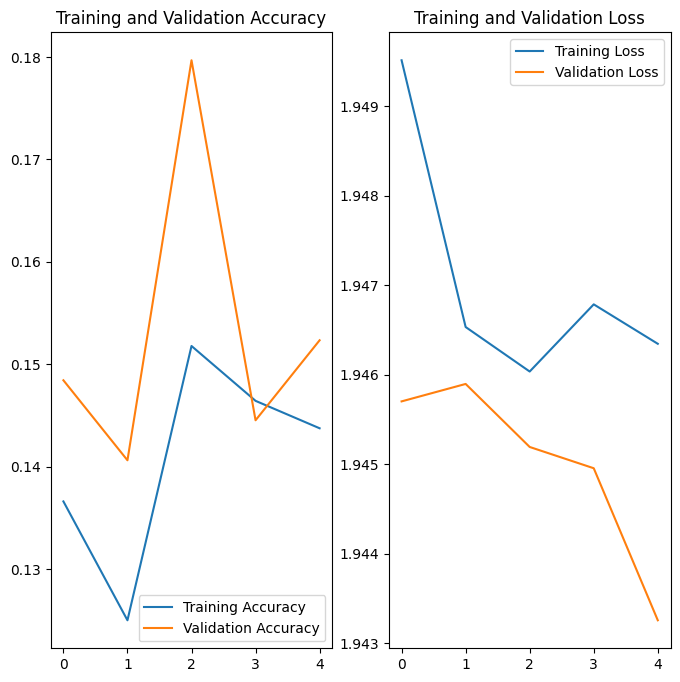

In [ ]:
# Graficar resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_true = []
y_pred = []

# Recorrer el generador de validación
for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    preds = attention_model.predict(x_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Obtener nombres de clases
class_names = list(validation_generator.class_indices.keys())

# Imprimir classification report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       blink       0.00      0.00      0.00        40
brows_lifted       0.14      1.00      0.25        40
  mouth_open       0.00      0.00      0.00        40
     neutral       0.00      0.00      0.00        40
       smile       0.00      0.00      0.00        40
   wink_left       0.00      0.00      0.00        40
  wink_right       0.00      0.00      0.00        40

    accuracy                           0.14       280
   macro avg       0.02      0.14      0.04       280
weighted avg       0.02      0.14      0.04       280



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from collections import Counter
print(Counter(y_pred))


Counter({np.int64(1): 280})


###RESNET


In [ ]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
normalized_dataset_inner = os.path.join(normalized_dataset_path, os.listdir(normalized_dataset_path)[0])
dataset_path = normalized_dataset_inner


In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.7MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Recomendado para ResNet
    transforms.ToTensor(),
])

# Dataset completo
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

# División 80/20
indices = list(range(len(full_dataset)))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=full_dataset.targets, random_state=42
)

train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_acc = val_correct / val_total

    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"[{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


[1/10] Train Loss: 0.9237 | Train Acc: 0.6562 || Val Loss: 1.6566 | Val Acc: 0.5929
[2/10] Train Loss: 0.3357 | Train Acc: 0.8732 || Val Loss: 0.9427 | Val Acc: 0.7321
[3/10] Train Loss: 0.2732 | Train Acc: 0.9036 || Val Loss: 2.0529 | Val Acc: 0.5071
[4/10] Train Loss: 0.2970 | Train Acc: 0.8839 || Val Loss: 0.8260 | Val Acc: 0.7071
[5/10] Train Loss: 0.2336 | Train Acc: 0.9045 || Val Loss: 0.8700 | Val Acc: 0.7464
[6/10] Train Loss: 0.2142 | Train Acc: 0.9187 || Val Loss: 0.4885 | Val Acc: 0.8286
[7/10] Train Loss: 0.1650 | Train Acc: 0.9313 || Val Loss: 0.7554 | Val Acc: 0.7786
[8/10] Train Loss: 0.1430 | Train Acc: 0.9437 || Val Loss: 0.4885 | Val Acc: 0.8321
[9/10] Train Loss: 0.1796 | Train Acc: 0.9277 || Val Loss: 0.8614 | Val Acc: 0.7071
[10/10] Train Loss: 0.1875 | Train Acc: 0.9304 || Val Loss: 0.6599 | Val Acc: 0.8000


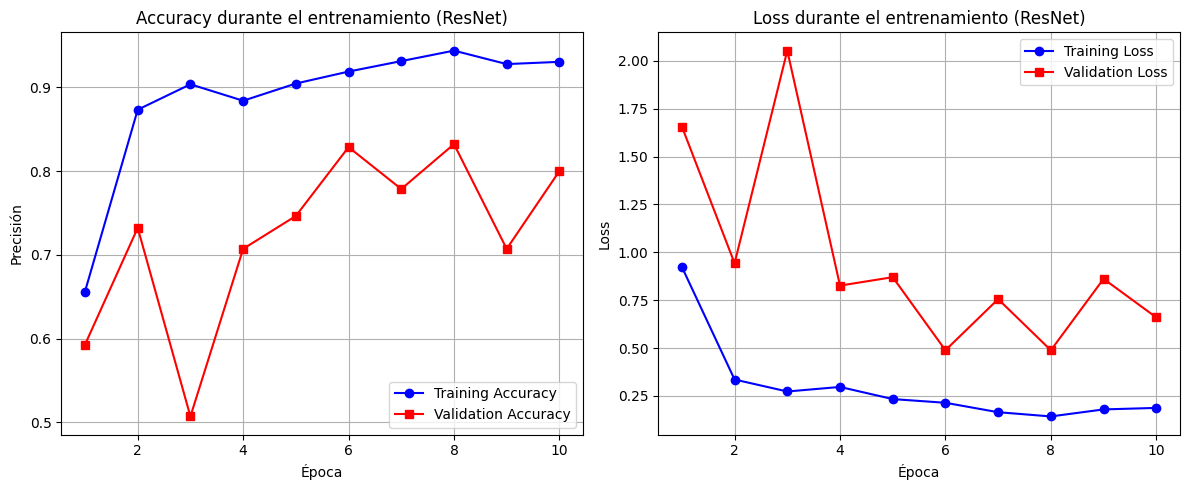

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy', color='red', marker='s')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Accuracy durante el entrenamiento (ResNet)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss_list, label='Validation Loss', color='red', marker='s')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss durante el entrenamiento (ResNet)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


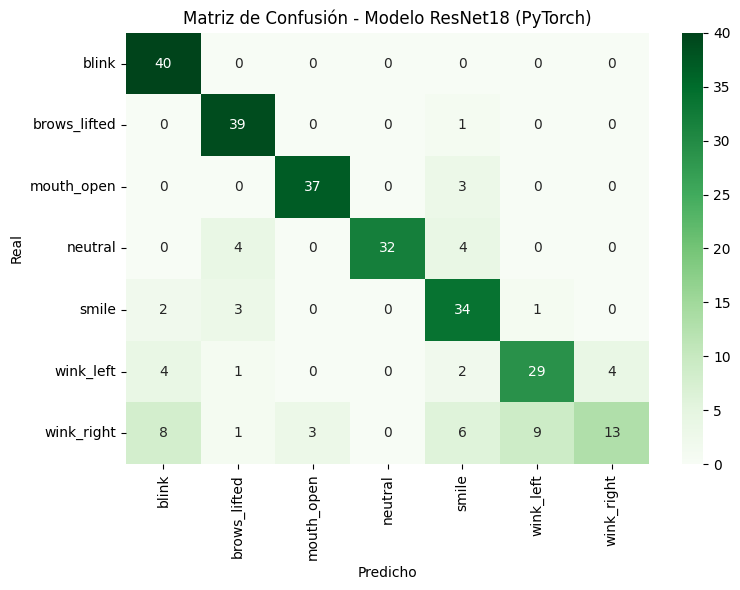

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Matriz de confusión para ResNet
cm_resnet = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo ResNet18 (PyTorch)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

       blink       0.74      1.00      0.85        40
brows_lifted       0.81      0.97      0.89        40
  mouth_open       0.93      0.93      0.93        40
     neutral       1.00      0.80      0.89        40
       smile       0.68      0.85      0.76        40
   wink_left       0.74      0.72      0.73        40
  wink_right       0.76      0.33      0.46        40

    accuracy                           0.80       280
   macro avg       0.81      0.80      0.79       280
weighted avg       0.81      0.80      0.79       280

